# PINNs

Consideremos la misma ecuación diferencial, resuelta en el notebook anterior con el método de residuos de ponderación: 

$$\frac{d^2u}{dx^2} + u + x = 0 \enspace , $$

con condiciones de frontera $u(0)=u(1)=0$.

La solución a este problema de valores de la frontera es

$$u_e(x) = \frac{\sin(x)}{\sin(1)} - x \enspace ,$$

In [17]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Configuracion graficos
gris = '#757575'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["text.color"] = gris
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.color"] = gris
plt.rcParams["ytick.color"] = gris
plt.rcParams["axes.labelcolor"] = gris
plt.rcParams["axes.edgecolor"] = gris
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

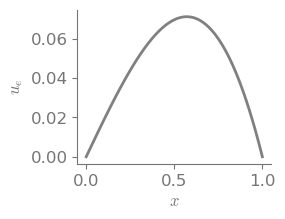

In [22]:
x = torch.linspace(0,1,100).view(-1,1)
u_e = torch.sin(x)/torch.sin(torch.tensor(1)) - x

# Create a figure for the plot
fig = plt.figure(figsize=(2.5, 2.0))

plt.plot(x,u_e,color='gray', linewidth=2)

# Set the title and labels for the x and y axes
plt.xlabel('$x$')
plt.ylabel('$u_{e}$')

# Display the plot
plt.show()

In [43]:
x_physics = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)


# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 10)
        self.layer2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
model = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [44]:
torch.manual_seed(123)

files = []
for i in range(1_001):
    optimizer.zero_grad()
    uh = model(x_physics)
    dudx  = torch.autograd.grad(uh, x_physics, torch.ones_like(uh), create_graph=True)[0]  # computes du/dx
    dudx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(dudx), create_graph=True)[0]  # computes d^2u/dx^2
    physics = dudx2 + uh + x_physics 
    loss = torch.mean(physics**2)
    # Add boundary conditions to the loss
    bc_loss = loss_func(uh[0], torch.tensor([0.])) + loss_func(uh[-1], torch.tensor([0.]))
    loss += bc_loss    
    # backpropagate loss
    loss.backward()
    optimizer.step()

    # Print progress every 1000 iterations
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 0.3766207695007324
Iteration 100, Loss: 0.0007746991468593478
Iteration 200, Loss: 0.0001620390103198588
Iteration 300, Loss: 4.247565448167734e-05
Iteration 400, Loss: 2.6469570002518594e-05
Iteration 500, Loss: 2.145311373169534e-05
Iteration 600, Loss: 1.7592959920875728e-05
Iteration 700, Loss: 1.4444516637013294e-05
Iteration 800, Loss: 1.1896996511495672e-05
Iteration 900, Loss: 1.2983892702322919e-05
Iteration 1000, Loss: 9.565173968439922e-06


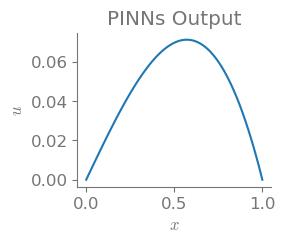

In [46]:
import matplotlib.pyplot as plt

# Generate predictions
model.eval()  # set the model to evaluation mode
with torch.no_grad():  # turn off gradients for the prediction
    predictions = model(x_physics)

# Convert tensors to numpy arrays for plotting
x = x_physics.detach().numpy()
y = predictions.detach().numpy()

# Create a figure for the plot
fig = plt.figure(figsize=(2.5, 2.0))

# Plot the predictions
plt.plot(x, y)

# Set the title and labels
plt.title('PINNs Output')
plt.xlabel('$x$')
plt.ylabel('$u$')

# Display the plot
plt.show()